*   OBJECTIVE: identify from which camera an image was taken
*   DATASET: https://www.kaggle.com/c/sp-society-camera-model-identification/data
*   MODEL: pretrained mobilenet v2
*   OUTCOME: accuracy of 94.15% achieved on the validation dataset



In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

from time import sleep
from tqdm import tqdm
from tqdm import trange

from pytorch_lightning.metrics.functional import accuracy

import albumentations as A

In [ ]:
device = torch.device("cuda:0") 

In [ ]:
batch_size_train = 16
batch_size_val = 16

In [ ]:
 # load mobilenet_v2 model

model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)
print(model.classifier)

# change the number of output features

model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
print(model.classifier)

model.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/sp-society-camera-model-identification.zip" -d "/content/drive/MyDrive/sp-society-camera-model-identification"

In [ ]:
# define data augmentation

transform = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

aug = A.Compose([
    A.HorizontalFlip(p=0.1),
    A.Blur(p=0.1), 
    A.RandomBrightnessContrast (brightness_limit=0.4, contrast_limit=0.2, p=0.1)
], additional_targets={'image0': 'image', 'image1': 'image', 'image2': 'image',
                       'image3': 'image', 'image4': 'image', 'image5': 'image',
                       'image6': 'image', 'image7': 'image', 'image8': 'image',
                       'image9': 'image', 'image10': 'image', 'image11': 'image',
                       'image12': 'image', 'image13': 'image', 'image14': 'image'})

In [ ]:
# load train dataset

train_set = datasets.ImageFolder("/content/drive/MyDrive/sp-society-camera-model-identification/train/train",
                                 transform = transform)

In [ ]:
print(train_set.class_to_idx)

{'HTC-1-M7': 0, 'LG-Nexus-5x': 1, 'Motorola-Droid-Maxx': 2, 'Motorola-Nexus-6': 3, 'Motorola-X': 4, 'Samsung-Galaxy-Note3': 5, 'Samsung-Galaxy-S4': 6, 'Sony-NEX-7': 7, 'iPhone-4s': 8, 'iPhone-6': 9}


In [ ]:
# split train dataset into train and validation

train_dataset, val_dataset = torch.utils.data.random_split(train_set, [2000, 750])

In [ ]:
# use dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

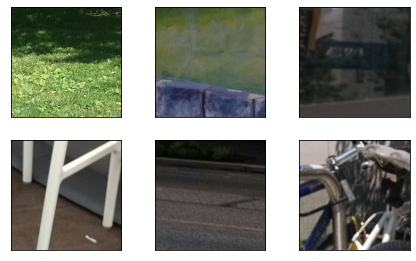

In [ ]:
#Normalization for image representation purpose was temporarily disabled 

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  image = np.moveaxis(np.array(example_data[i]), 0, -1)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

In [ ]:
# the main function to train the model

def train(model, train_loader):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)    
    # to reduce learning rate on plateau the corresponding scheduler is applied
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    
    epochs = 10
    epoch_loss = [0]*epochs
    epoch_accuracy = [0]*epochs
        
    train_losses = []
    train_counter = []
    log_interval = 15
    
    for e in range(epochs):
      running_loss = 0
      running_accuracy = 0

      with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (images, labels) in enumerate(tepoch):

            tepoch.set_description(f"Epoch {e}")
            images = np.array(images)
            # add augmentation
            transformed = aug(image=images[0], image0=images[1], image1=images[2], 
                              image2=images[3], image3=images[4], image4=images[5], 
                              image5=images[6], image6=images[7], image7=images[8],
                              image8=images[9], image9=images[10], image10=images[11], 
                              image11=images[12], image12=images[13], image13=images[14], 
                              image14=images[15])
            
            images = torch.Tensor(list(transformed.values()))
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
        
            output = model(images)
            loss = loss_fn(output, labels)
        
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % log_interval == 0:
                train_losses.append(loss.item())
                train_counter.append((batch_idx*batch_size_train) + (e*len(train_loader.dataset)))
                
            running_accuracy += accuracy(F.softmax(output, dim=1), labels)

            sleep(0.1)

        val_loss, val_acc = test(model, val_loader)
        scheduler.step(val_loss)
            
        epoch_loss[e] = running_loss/len(train_loader)
        epoch_accuracy[e] = running_accuracy/len(train_loader)
        
        print("Epoch {} \n Training: loss - {}, accuracy - {} \n Validation: loss - {}, accuracy - {}"
              .format(e, epoch_loss[e], epoch_accuracy[e], val_loss, val_acc))
        
    
    fig, (ax1, ax2) = plt.subplots(1,2)

    fig.set_figwidth(20)
    fig.set_figheight(7)

    ax1.plot(range(epochs), epoch_loss)
    ax2.plot(train_counter, train_losses)
    
    ax1.set(xlabel="Epoch", ylabel="Loss")
    ax2.set(xlabel="Number of training examples seen", ylabel="Loss")


In [ ]:
# this function calculates a loss value on the validation dataset

def test(model, val_loader):
    loss_fn = torch.nn.CrossEntropyLoss()
    running_loss = 0
    running_accuracy = 0
    
    for images, labels in val_loader:
        with torch.no_grad():
          
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            
            running_loss += loss_fn(output, labels)
            running_accuracy += accuracy(F.softmax(output, dim=1), labels)
            
    running_loss /= len(val_loader)
    running_accuracy /= len(val_loader)
    
    return running_loss, running_accuracy

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 0 
 Training: loss - 0.2455628126859665, accuracy - 0.9190000295639038 
 Validation: loss - 0.2015940248966217, accuracy - 0.92002272605896


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 1 
 Training: loss - 0.1874636802878231, accuracy - 0.940500020980835 
 Validation: loss - 0.1836976706981659, accuracy - 0.9426290988922119


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 2 
 Training: loss - 0.21947630752436817, accuracy - 0.9305000305175781 
 Validation: loss - 0.18157434463500977, accuracy - 0.9454786777496338


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 3 
 Training: loss - 0.14659052831679584, accuracy - 0.9535000324249268 
 Validation: loss - 0.1837427020072937, accuracy - 0.937309980392456


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 4 
 Training: loss - 0.19053485841676593, accuracy - 0.9345000386238098 
 Validation: loss - 0.18823988735675812, accuracy - 0.9308510422706604


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 5 
 Training: loss - 0.20898632453940807, accuracy - 0.9315000176429749 
 Validation: loss - 0.1856764703989029, accuracy - 0.9361701607704163


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 6 
 Training: loss - 0.19658273486047984, accuracy - 0.9375000596046448 
 Validation: loss - 0.17347638309001923, accuracy - 0.938829779624939


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 7 
 Training: loss - 0.15334796061366796, accuracy - 0.95250004529953 
 Validation: loss - 0.1931719183921814, accuracy - 0.9335106015205383


  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 8 
 Training: loss - 0.16048451555892826, accuracy - 0.9480000734329224 
 Validation: loss - 0.19112403690814972, accuracy - 0.9424391984939575


Epoch 9: 100%|██████████| 125/125 [08:11<00:00,  3.93s/batch]


Epoch 9 
 Training: loss - 0.2049971868712455, accuracy - 0.9350000619888306 
 Validation: loss - 0.16076025366783142, accuracy - 0.9414893388748169


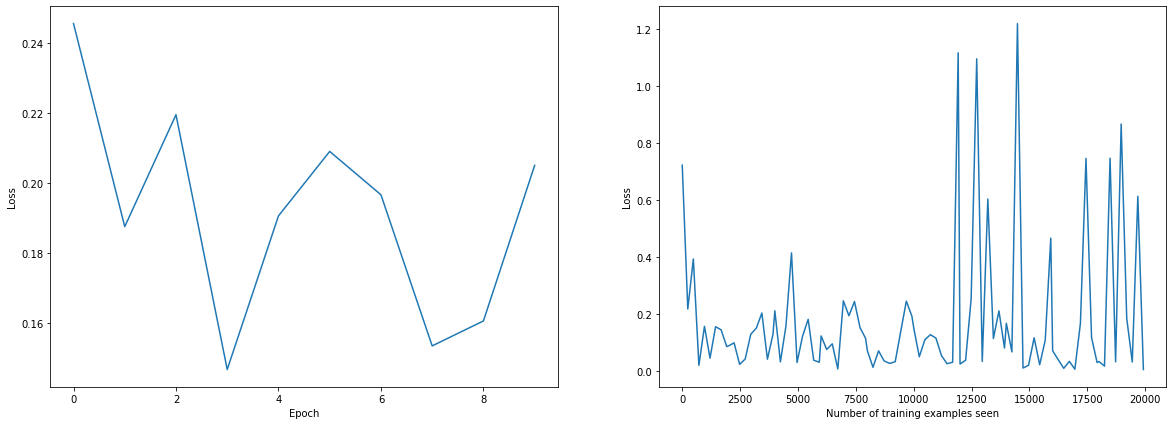

In [ ]:
# the model is trained on augmented images
# validation loss is calculated using initial images

train(model, train_loader)